# Module 2: Water flow in soil

*by Daniel Leitner, Andrea Schnepf, Valentin Couvreur, Axelle Koch*

## Theory


Water flow in soil is described by the Richards equation, which is given by 
\begin{eqnarray} \label{eq:rich1d}
\frac{\partial \theta}{\partial t}=  \nabla \cdot\left( K_c(\theta) \left( \nabla \psi_s - e_3 \right) \right),
\end{eqnarray}
in three dimesnions, where $\theta$ is the water content [1], $K_c$ is the hydraulic conductivity [cm / day], and  $\psi_s$ is the soil matric potential [cm]. 


The relationship between soil water potential and water content is generally described by the water retention curve. In the following we will use the Mualem Van Genuchten model (Van Genuchten, 1980) to describe this curve specifying the soil moisture characteristic of specific soils. 

## Benchmarks


Benchmarks for water movement in soil were developed by Vanderborght et al. (2005). In the following we will shortly describe two relevant benchmarks and implement their analytical solutions. The derivation is given by Vanderborght et al. (2005).  

In the following benchmarks soil properties are described by the Mualem Van Genuchten model (Van Genuchten, 1980). We will first import libraries and define some auxiliary functions:

In [1]:
import numpy as np
from scipy import optimize
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from math import * 
import os
import ast

In [2]:
# Mualem - van Genuchten model, equations from van Genuchten, MT (1980)

# class containing the van genuchten parameters
class Parameters:
    def __init__(self, R, S, alpha, n, Ksat):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = 1.-1./n
        self.Ksat = Ksat       

# returns the volumetric water content at a given pressure head  according to the van genuchten model (Eqn 21)
def water_content(h, sp):
    return sp.theta_R + (sp.theta_S-sp.theta_R)/pow(1. + pow(sp.alpha*abs(h),sp.n),sp.m)

# returns pressure head at a given volumetric water content according to the van genuchten model
def pressure_head(theta, sp): 
    theta = min(theta,sp.theta_S) # saturated water conent is the maximum 
    return - pow( pow( (sp.theta_S - sp.theta_R)/(theta - sp.theta_R), (1./sp.m))-1., 1./sp.n) / sp.alpha

# returns the effective saturation according to the van genuchten model (dimensionless water content, Eqn 2)
def effective_saturation(h,sp):
    h = min(h,0) # pressure head is negative, zero the maximum
    theta = water_content(h,sp)
    se = (theta-sp.theta_R)/(sp.theta_S-sp.theta_R)
    return se

# returns the hydraulic conductivity according to the van genuchten model (Eqn 8)
def hydraulic_conductivity(h,sp):
    se = effective_saturation(h,sp) 
    K = sp.Ksat*sqrt(se)*( (1. - pow(1. - pow(se, 1. / sp.m),sp.m)) ** 2 )
    return K 

# returns the specific moisture storage according to the van genuchten model
def specific_moisture_storage(h,sp):
    C = -sp.alpha*sp.n*np.sign(h)*(1. / sp.n - 1.) * pow(sp.alpha*abs(h), sp.n-1.) * (sp.theta_R-sp.theta_S) * pow(pow(sp.alpha*abs(h),sp.n) + 1., 1./sp.n-2.)
    return C

# returns the water diffusivity (Eqn 11)
def water_diffusivity(TH, theta_i, theta_sur, sp):
    theta = TH * (theta_i - theta_sur) + theta_sur
    Se = (theta - sp.theta_R) / (sp.theta_S - sp.theta_R)
    m = sp.m
    D = (1 - m) * sp.Ksat / (sp.alpha * m * (sp.theta_S - sp.theta_R)) * pow(Se, 0.5 - 1. / m) * (pow(1 - pow(Se, 1. / m), -m) + pow(1 - pow(Se, 1 / m), m) - 2)
    return D

The benchmarks use the following soil types (from the soil catalogue of Hydrus 1D), the parameters are $\theta_r$ [1], $\theta_s$ [1], $\alpha$ [1/cm], $n$ [1], and $K_s$ [cm / day]:

In [3]:
sand = Parameters(0.045, 0.43, 0.15, 3, 1000) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50)
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10)

### Benchmark M2.1: Infiltration


We consider three scenarios: sand, loam, and clay. All soil profiles are 200 cm deep, an initially the soil is dry with a matric potential of -400 cm everywhere. 

At the top boundary we prescribe an influx of 100 cm/day if the soil matric potential is negative ($\psi_s(z=0) < 0$ cm), else we prescribe full saturation as Dirichlet boundary condition ($\psi_s(z=0)= 0$ cm). At the bottom free drainage boundary conditions is used.

We are interested in the dynamics of the infiltration front. 

The analytical solution of Benchmark M2.1 is calculated by the following code and reproduces Figure 4abc from Vanderborght et al. (2005), where the water content is plotted for different times: 0.1, 0.2, and 0.3 days for Scenario 1; 0.2, 0.5, and 1 days for Scenario 2; 0.1, 0.2, and 0.5 days for Scenario 3.

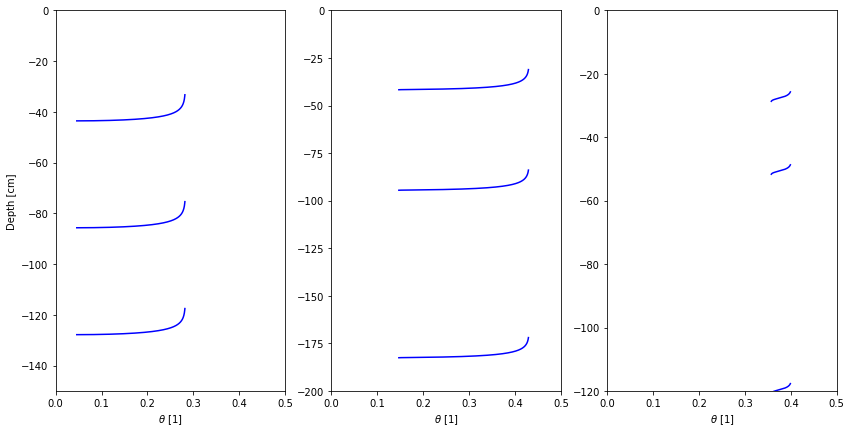

In [4]:
tv=[ [0.1, 0.2, 0.3], [0.2, 0.5, 1.0], [0.1, 0.2, 0.5] ] # time values (days)
t_a2 = [0.1, 0.2, 0.1] 
x_aa = [43, 41, 27.5] # TODO how to choose reference water content and its position ?    

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7))
ax = [ax1,ax2,ax3]
theta3 = []
z3 = []

for i, soil in enumerate([sand, loam, clay]): # make three subplots
        
    if soil==sand:
        theta_sur = 0.2824 # calculated form the influx 100 cm/day
    else:
        theta_sur = soil.theta_S  # full saturation          
    theta_i = water_content(-400,soil);
        
    K_sur = hydraulic_conductivity( pressure_head(theta_sur,soil), soil);
    K_i = hydraulic_conductivity(-400, soil)
    psi = lambda theta: pressure_head(theta,soil)
    K = lambda psi: hydraulic_conductivity(psi,soil)
    Dw = lambda psi: K(psi)/(specific_moisture_storage(psi,soil))            
    F = lambda theta:  Dw(psi(theta)) / ( (K_sur - K_i)*(theta - theta_i) - (K(psi(theta)) - K_i)*(theta_sur - theta_i) ) 
    
    theta_a = (theta_sur+theta_i)/2
    theta_ = np.linspace (theta_i+1e-3,theta_sur-1e-3,1000)

    delta_eta = np.zeros(len(theta_),)
    for j in range(0,len(theta_)):
        ans, err = integrate.quad(F,theta_[j],theta_a)
        delta_eta[j] = ans
    
    delta_eta = delta_eta * (theta_sur - theta_i)
    x_a = x_aa[i]
    t_a = t_a2[i]        
    eta_a = x_a - (K_sur-K_i)/(theta_sur - theta_i)*t_a
    eta = delta_eta + eta_a

    # finally, plot the thing    
    for j in range(0,len(tv[0])):
        t = tv[i][j]
        x = eta  + (K_sur - K_i) * t / (theta_sur - theta_i);
        ax[i].plot(theta_,-x,'b-')
        theta3.append(theta_) # remember results for evaluation
        z3.append(-x)
    ax[i].set_xlabel(r'$\theta$ [1]')
    ax[i].set_xlim(0,0.5)

ax1.set_ylabel('Depth [cm]')
ax1.set_ylim(-150,0)
ax2.set_ylim(-200,0)
ax3.set_ylim(-120,0)
plt.show()

### Benchmark M2.2: Evaporation

For Benchmark M2.2 we consider four scenarios: (1) sand, (2) loam, (3) loam, and (4) clay, all profiles with a depth of 100 cm. Initially, we assume a soil matric potential of -40 cm for scenario (1) and -200 cm for all other soils. 

At top we choose an eflux of 0.1 cm/day for scenario (1) and (2), and 0.3 cm/day for (3) and (4), if the water soil potential is higher than a critical value $\psi_s(z=0)>-10000$ cm. If it is lower, we set the matric potential to the critical value with a Dirichlet boundary condition, i.e. $\psi_s(z=0) = -10000$ cm. At the bottom we assume no flux.

We are interested in the actual evaporation over time.

The analytical solution of this benchmark is calculated by the following code and reproduces Figure 5abcd from Vanderborght et al. (2005). 


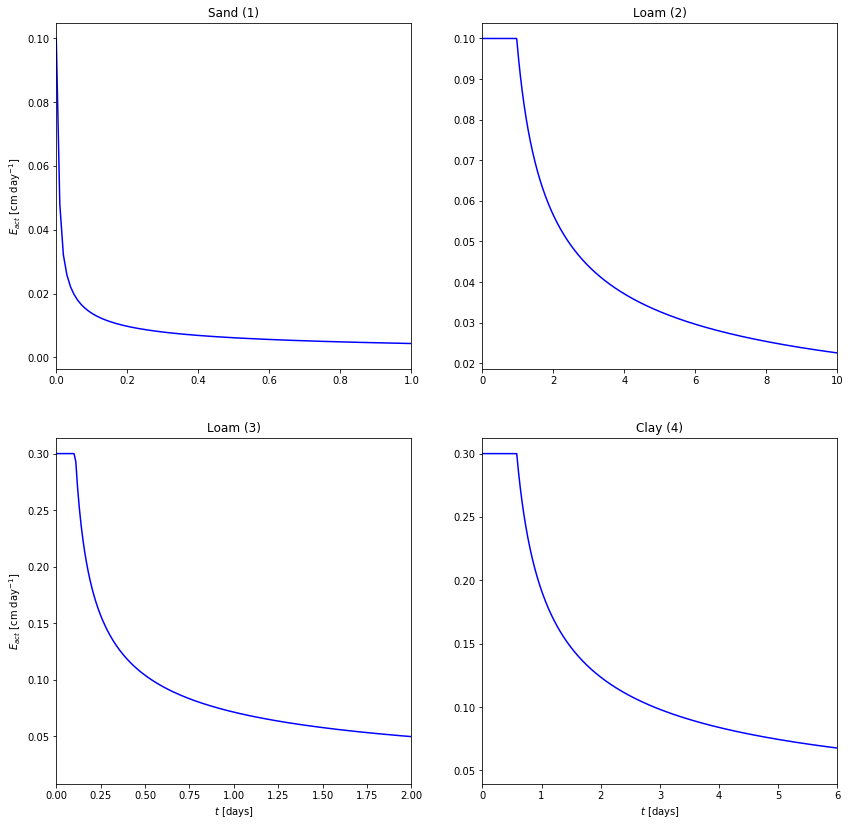

In [5]:
jwpot_ = [-0.1, -0.1, -0.3, -0.3] # potential eflux (cm/day)
head_i_ = [-40, -200, -200, -200] # initial soil matric potential (cm)

N = 1000
y = np.zeros((N,4))
t = np.linspace(0,10,N) # days

for i,soil in enumerate([sand, loam, loam, clay]):  
    
    head_i = head_i_[i]
    theta_i = water_content(head_i,soil) # initial theta  
    theta_sur = water_content(-10000,soil) # critical vaule 
    jwpot = jwpot_[i]      
    
    dw = lambda TH: water_diffusivity(TH,theta_i, theta_sur, soil)    
    int_dw, err = integrate.quad(dw,0,1)    
  
    theta_dw = lambda TH: TH*water_diffusivity(TH,theta_i, theta_sur, soil)       
    int_theta_dw, err = integrate.quad(theta_dw,0,1)
    beta = pow(int_theta_dw/int_dw,2) # Eqn 43

    fun_dw = lambda TH: pow(1-TH*beta,2)*dw(TH)
    alpha, err = integrate.quad(fun_dw,0,1)
    alpha /= int_dw  # Eqn 42

    mu = ( 3*beta*(1+sqrt(1-(14/9)*(1-alpha/pow(1-beta,2)) ) ) ) / ( 2*(1-beta)*(alpha/pow(1-beta,2)-1) ) # Eqb 41
    sw = lambda theta_sur, theta_i: (theta_i-theta_sur)*sqrt((4/mu)*int_dw) # Eqn 39  
    tdash = (sw(theta_sur, theta_i)*sw(theta_sur, theta_i)) / (4*jwpot*jwpot) # Eqn 44
    tpot =  (sw(theta_sur, theta_i)*sw(theta_sur, theta_i)) / (2*jwpot*jwpot) # Eqn 45
    jw = lambda t: (t<tpot)*jwpot+(t>=tpot)*sw(theta_sur, theta_i)/(2*sqrt(abs(tdash+t-tpot))) # eq 46 & 47

    y[:,i] = list(map(jw,t))  # evaluate

# prepare plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14))    
ax1.plot(t,abs(y[:,0]),'b')
ax1.set_ylabel('$E_{act}$ [cm day$^{-1}$]')
ax1.set_xlim(0,1)
ax1.set_title("Sand (1)")
ax2.plot(t,abs(y[:,1]),'b')
ax2.set_xlim(0,10)
ax2.set_title("Loam (2)")
ax3.plot(t,abs(y[:,2]),'b')
ax3.set_xlabel('$t$ [days]')
ax3.set_ylabel('$E_{act}$ [cm day$^{-1}$]')
ax3.set_xlim(0,2)
ax3.set_title("Loam (3)")
ax4.plot(t,abs(y[:,3]),'b')
ax4.set_xlabel('$t$ [days]')
ax4.set_xlim(0,6)
ax4.set_title("Clay (4)")
plt.show()

t4 = t # remember results for later
y4 = abs(y)

## Comparison to numerical solutions

Benchmark M2.1 and M2.2 was evaluated for *Macro*, *Hydrus1D*, *Swap*, *Marthe*, and *Wave* in Vanderborght et al. (2005). 

We validate additional numerical codes by solving the benchmarking problems. In the following we link to notebooks, containing all or some of above benchmarks: 

* [Dumux](Soil water flow - Dumux.ipynb)


There are many softwares solving Richards equation. What are the most important features, and which softwares are most suitable for a specific purpose. 

* Availability and license 
* Dimensions: 1D, 1D axial symmetric, 3D
* Mass conservation
* Parallel computing
* Support of unstructured meshes and adaptive refinement


### Benchmark M2.1

For an automatic comparison of the numerical results, save the results in a text file, each result consisting of two rows containing comma separated depth values [cm] in the first, and water content [1] in the second. This is done for each time point and infiltration scenario (i.e. 3 (time points) * 3 (scenarios) results = 18 rows). Copy the file to the folder /soil_water_flow/b3/.

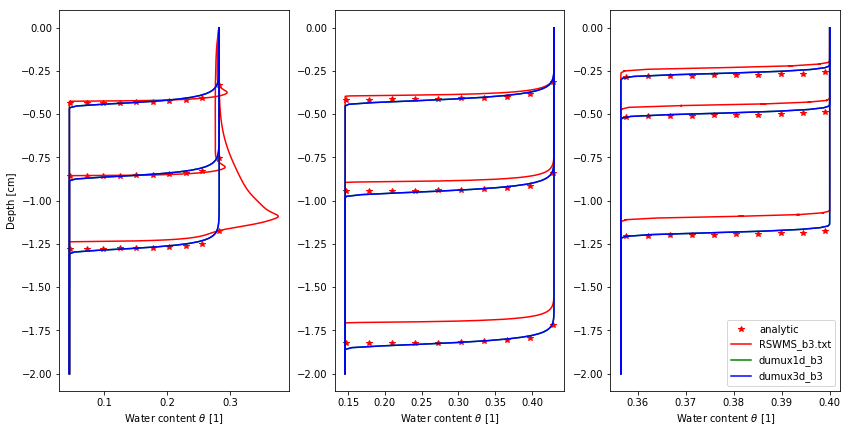

Name		 N	 R²		 R
RSWMS_b3.txt	 801 	 0.36595823 	 -0.60494481
RSWMS_b3.txt	 801 	 0.60364578 	 -0.77694645
RSWMS_b3.txt	 801 	 0.61658986 	 -0.78523236
RSWMS_b3.txt	 801 	 0.44835974 	 -0.66959670
RSWMS_b3.txt	 801 	 0.76163019 	 -0.87271426
RSWMS_b3.txt	 801 	 0.48056071 	 -0.69322486
RSWMS_b3.txt	 804 	 0.31783274 	 -0.56376656
RSWMS_b3.txt	 804 	 0.53020938 	 -0.72815477
RSWMS_b3.txt	 804 	 0.75684862 	 -0.86997047
dumux1d_b3	 200 	 0.47754787 	 0.69104838
dumux1d_b3	 200 	 0.75364943 	 0.86812985
dumux1d_b3	 200 	 0.76795739 	 0.87633178
dumux1d_b3	 200 	 0.46613504 	 0.68274083
dumux1d_b3	 200 	 0.77556099 	 0.88065941
dumux1d_b3	 200 	 0.37594834 	 0.61314626
dumux1d_b3	 200 	 0.35715481 	 0.59762430
dumux1d_b3	 200 	 0.57132969 	 0.75586354
dumux1d_b3	 200 	 0.74352106 	 0.86227667
dumux3d_b3	 20700 	 0.47435988 	 0.68873789
dumux3d_b3	 20700 	 0.75482198 	 0.86880492
dumux3d_b3	 20700 	 0.76766236 	 0.87616343
dumux3d_b3	 20700 	 0.46321305 	 0.68059757
dumux3d_b3	 20700 	 0.77

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))  
for j in range(0,3): # axis
    for k in range(0,3): 
        z = z3[3*j+k]
        theta = theta3[3*j+k]
        interp = interp1d(theta, z,  kind='linear', fill_value='extrapolate', bounds_error =False ) 
        theta_ = np.linspace(np.min(theta),np.max(theta),10)        
        pl, = ax[j].plot(theta_,interp(theta_)/100,'r*')
        if k==0:
            pl.set_label("analytic") 
        
r, rsme, rsquare, nn, l = [], [], [], [], []
cc = 0
col = ['r','g','b','r','g','b']
for dirname, dirnames, filenames in os.walk('soil_water_flow/b3/.'):    
    filenames.sort()
    for i,f in enumerate(filenames):            
        try:        
            data = []
            with open('soil_water_flow/b3/'+f) as fp: 
                for line in fp:
                    s = ast.literal_eval("["+line+"]")                
                    data.append(s)                      
            for j in range(0,3): # axis
                for k in range(0,3): 
                    l.append(f)                    
                    z = data[2*(3*j+k)]
                    theta = data[2*(3*j+k)+1]                     
                    pl, = ax[j].plot(theta,z,col[cc]) # numeric solution                     
                    interp = interp1d(theta3[3*j+k], z3[3*j+k],  kind='linear', fill_value='extrapolate', bounds_error =False ) 
                    z_a = interp(sorted(theta)) # analytical solution at points                    
                    # Evaluate
                    oi, pi = z, z_a
                    om, pm = np.mean(oi), np.mean(pi)
                    nn.append(len(oi))
                    # calculate R
                    r_ =  np.sum((oi-om)*(pi-pm)) / (np.sqrt(np.sum(np.square(oi-om)))*np.sqrt(np.sum(np.square(pi-pm))) )
                    r.append(r_)
                    # calculate R^2
                    # r2 = np.sum(np.square(pi-om)) / np.sum(np.square(oi-om))                         
                    rsquare.append(r_*r_)            
                    # calculate RSME
                    rsme_ = np.square(np.sum(np.square(oi-pi)/nn[-1]))
                    rsme.append(rsme_)                                          
                    if k==0:
                        pl.set_label(f)                                      
                ax[j].set_xlabel("Water content $\\theta$ [1]")
                if j==0: 
                    ax[j].set_ylabel("Depth [cm]") # all file data values are currently [m], I will change that soon                                                                                             
            cc+=1                                  
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)                  
ax[-1].legend() 
plt.show()      

print("Name\t\t", "N\t", "R²\t\t", "R")
for i in range(0,len(nn)):
    print(l[i]+"\t",nn[i],"\t",'{:2.8f}'.format(rsquare[i]),"\t",'{:2.8f}'.format(r[i]) ) # '{:2.8f}'.format(rsme[i]),"\t",

### Benchmark M2.2

For an automatic comparison of the numerical results, save the results in a text file with two rows containing comma separated time points [day] in the first, and actual evaporation rate [cm day-1] in the second. This is done for each scenario, with low and high resolution (i.e. 4 (scenarios) * 2 (resolutions) results = 16 rows). Copy the file to the folder /soil_water_flow/b4/.

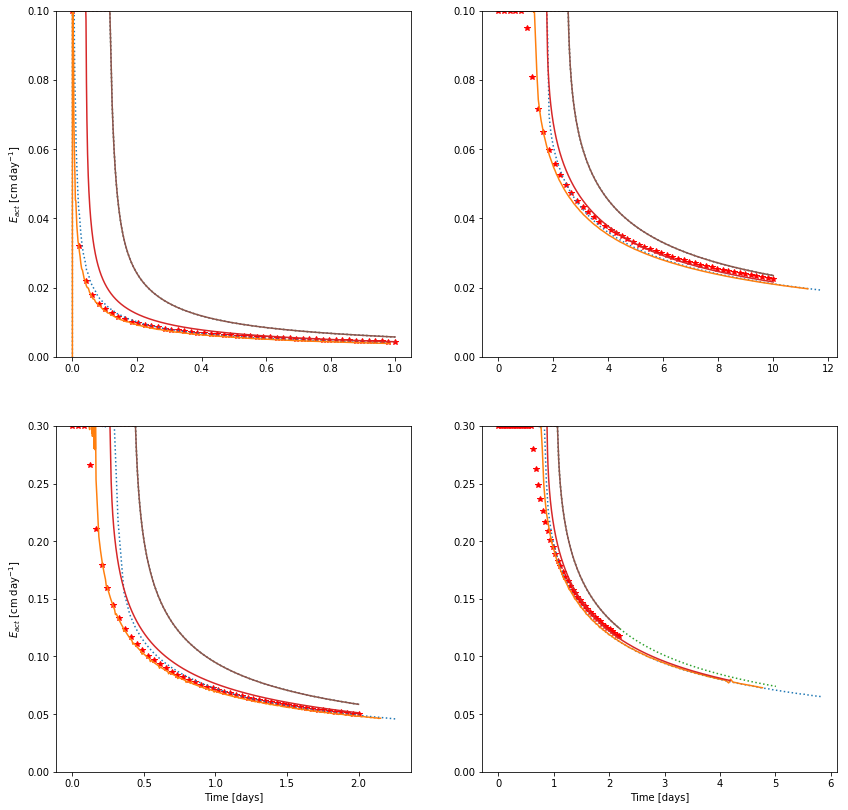

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))  

for j in range(0,4):   
    t = sorted(data[2*j])
    t_ = np.linspace(np.min(t),np.max(t),50)
    interp = interp1d(t4, y4[:,j],  kind='linear', fill_value='extrapolate' ) 
    ax[int(j/2),j%2].plot(t_,interp(t_),'r*')  
   
for dirname, dirnames, filenames in os.walk('soil_water_flow/b4/.'):
    filenames.sort()
    for i,f in enumerate(filenames):    
        try:              
            data = []
            with open('soil_water_flow/b4/'+f) as fp: 
                for line in fp:
                    s = ast.literal_eval("["+line+"]")  
                    data.append(s) 
                         
            for j in range(0,8): # 0-3 low res, 4-7 high res                
                t = data[2*j]                
                eva = data[2*j+1]                   
                j_ = j % 4 # scenario index (i.e. 0-3)                           
                interp = interp1d(t4, y4[:,j_],  kind='linear', fill_value='extrapolate' ) 
                eva_a = interp(sorted(t))
                if j>3: # R² values for higher discretizations
                    n = len(eva) # calculate R^2
                    r = 1 - ( np.sum(np.square(eva_a-eva)) / (np.sum(np.square(eva_a))-np.square(np.sum(eva_a))/n) )    
                    # print("R² =", r ,"( N =", n, ")\n")                
                    ax[int(j_/2),j_%2].plot(t,eva) # numeric solution 
                else:
                    ax[int(j_/2),j_%2].plot(t,eva,':') # numeric solution                                                                                                         
                if j_>1:
                    ax[int(j_/2),j_%2].set_xlabel("Time [days]")
                if j == 0 or j == 2:
                    ax[int(j_/2),j_%2].set_ylabel('$E_{act}$ [cm day$^{-1}$]')                       
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)
            
ax[0,0].set_ylim(0,0.1) 
ax[0,1].set_ylim(0,0.1) 
ax[1,0].set_ylim(0,0.3) 
ax[1,1].set_ylim(0,0.3) 
plt.show()

## References

Vanderborght, J and Kasteel, R and Herbst, M and Javaux, M and Thiery, D and Vanclooster, M and Mouvet, C and Vereecken, H (2005) A set of analytical benchmarks to test numerical models of flow and transport in soils. *Vadose Zone Journal*, 4(1):206-221

Van Genuchten, MT (1980) Closed-form equation for predicting the hydraulic conductivity of unsaturated soils. *Soil Science Society of America Journal* 44(5):892-898
